In [22]:
import json
import pandas as pd
import requests
import pprint
#import matplotlib.pyplot as plt
#from ipywidgets import interact
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math
#import plotly.express as px

In [7]:
#cdsurl = "https://dataservice-dev2.datacommons.cancer.gov/v1/graphql/"
cdsurl = "https://dataservice.datacommons.cancer.gov/v1/graphql/"

In [8]:
def runGraphQLQuery(url,query,variables):
    headers = {"content-type":"application/json"}
    try:
        if variables is None:
            #results = requests.post(url = url, json={"query":query, "headers":headers}, verify = False)
            results = requests.post(url = url, json={"query":query, "headers":headers})
        else:
            results = requests.post(url=url, json={"query":query, "headers":headers, "variables":variables})
        results = results.json()
    except requests.exceptions.HTTPError as exception:
        print(exception)
    return results

In [9]:
studyquery = """
{
  study{
    study_acronym
    study_name
    phs_accession
  }
}"""

In [10]:
studyres = runGraphQLQuery(cdsurl, studyquery, None)

In [11]:
phslist = []
for study in studyres['data']['study']:
    phslist.append(study['phs_accession'])

In [12]:
pprint.pprint(len(phslist))

17


In [13]:
filequery = """
query phsFiles($phs:String){
  study(phs_accession:$phs){
    files{
      file_id
      file_type
    }
  }
}"""

In [14]:
finalresult = {}
columns = ["PHS", "FileType", "Count"]
typecountdf = pd.DataFrame(columns = columns)

In [15]:
for phs in phslist:
    variables = {"phs":phs}
    filedict = {}
    fileres = runGraphQLQuery(cdsurl, filequery, variables)
    filelist = fileres['data']['study'][0]['files']
    for file in filelist:
        if file['file_type'] in filedict:
            filedict[file['file_type']].append(file['file_id'])
        else:
            filedict[file['file_type']] = [file['file_id']]
    finalresult[phs] = filedict

In [16]:
for phs, files in finalresult.items():
    for type, idlist in files.items():
        typecountdf.loc[len(typecountdf.index)] = [phs,type, len(idlist)]
        #pprint.pprint(len(idlist))
       # print(("phs:\t%s\tType:\t%s\tCount:\t%s")%(phs, type, len(idlist)))

In [24]:
typecountdf.head()

,PHS,FileType,Count
0,phs002790,CRAI,3462
1,phs002790,HTML,3255
2,phs002790,JSON,15179
3,phs002790,PDF,4698
4,phs002790,BAM,3396


In [25]:
def goPie(project, catdata):
    catlist = []
    countlist = []
    for category, count in catdata.items():
        catlist.append(category)
        countlist.append(count)
    fig = go.Pie(labels=catlist, values=countlist, title_text=project, textinfo='value')
    return fig

In [26]:
def plotlySubplots(jsondata, cols, rows, height, title):
    #Need to have a specs row for each row in the subplot and each row has to define each column
    collist = []
    x = 1
    while x <= cols:
        collist.append({'type': 'pie'})
        x += 1
    speclist =[]
    x = 1
    while x<= rows:
        speclist.append(collist)
        x +=1

    subfig = make_subplots(rows=rows, cols=cols, specs=speclist)
    tempcol = 1
    temprow = 1
    for project,data in jsondata.items():
        if data:
            fig = goPie(project, data)
            subfig.add_trace(fig,row = temprow, col = tempcol)  
            if tempcol == cols:
                tempcol = 1
                temprow = temprow + 1
            else:
                tempcol = tempcol + 1
        subfig.update_layout(height= height, title_text=title)
    return subfig  

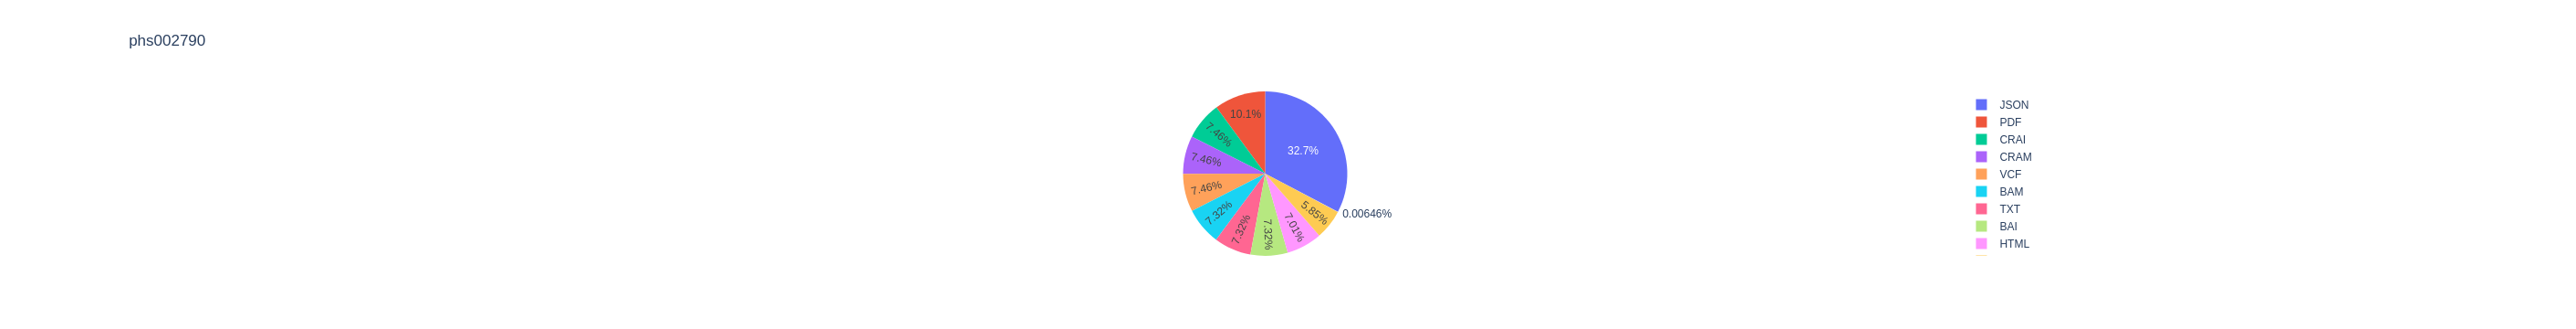

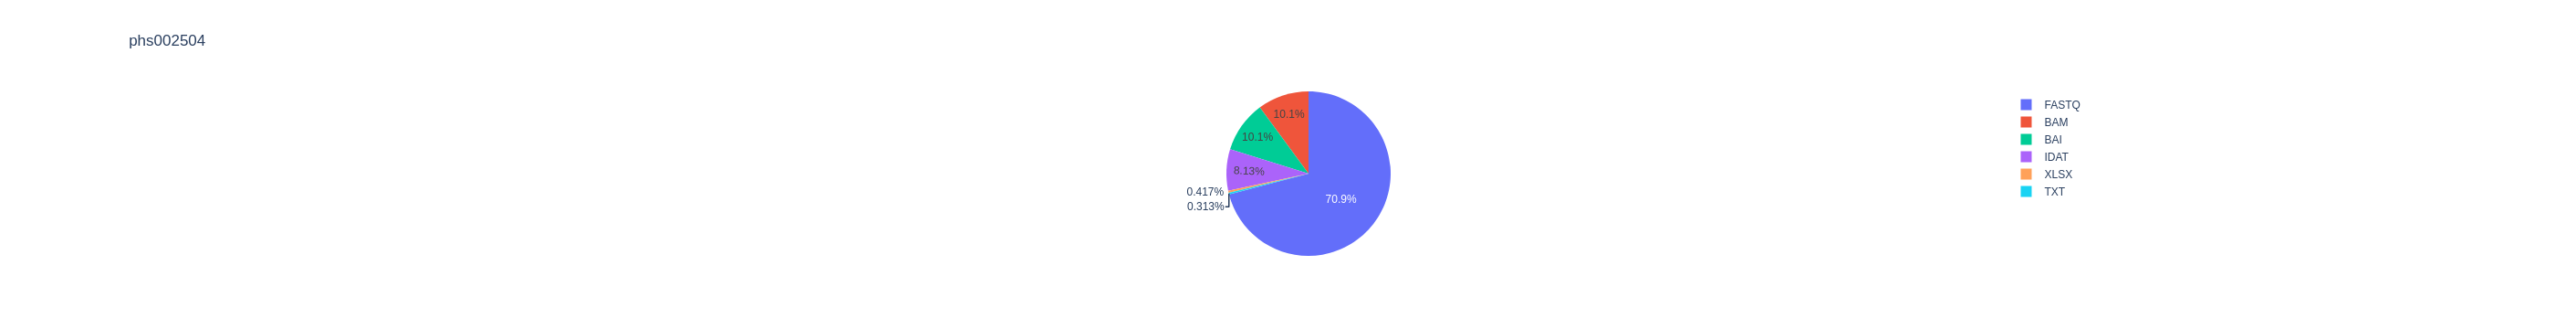

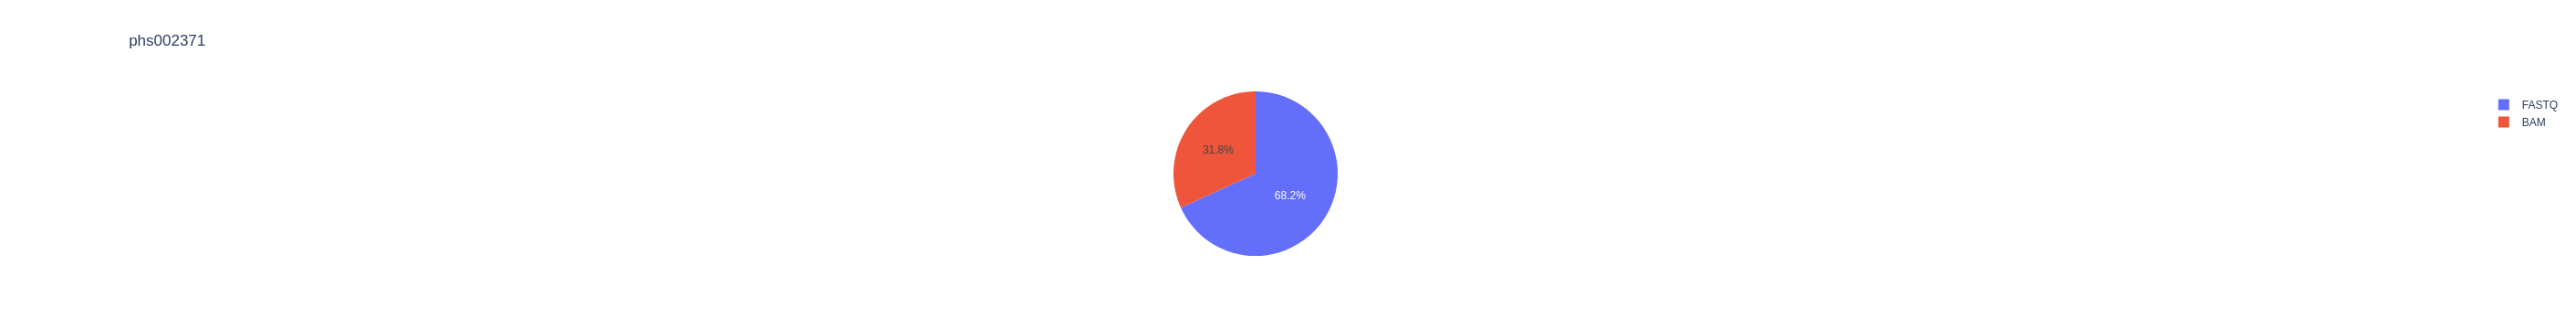

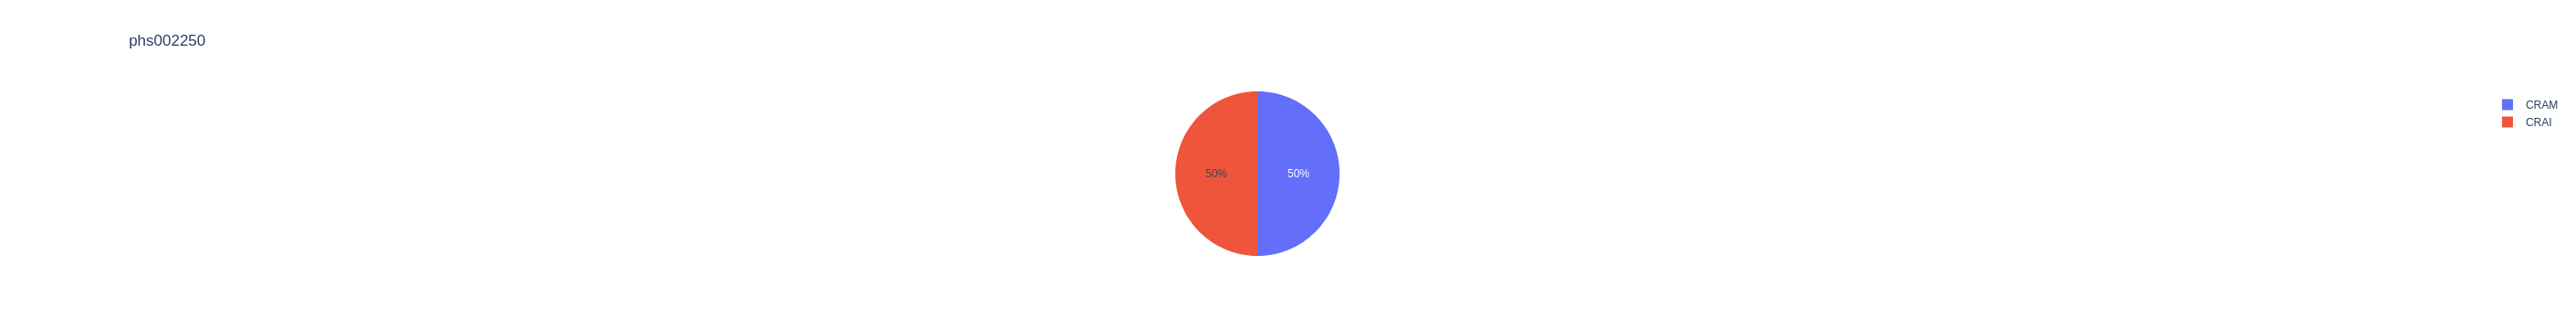

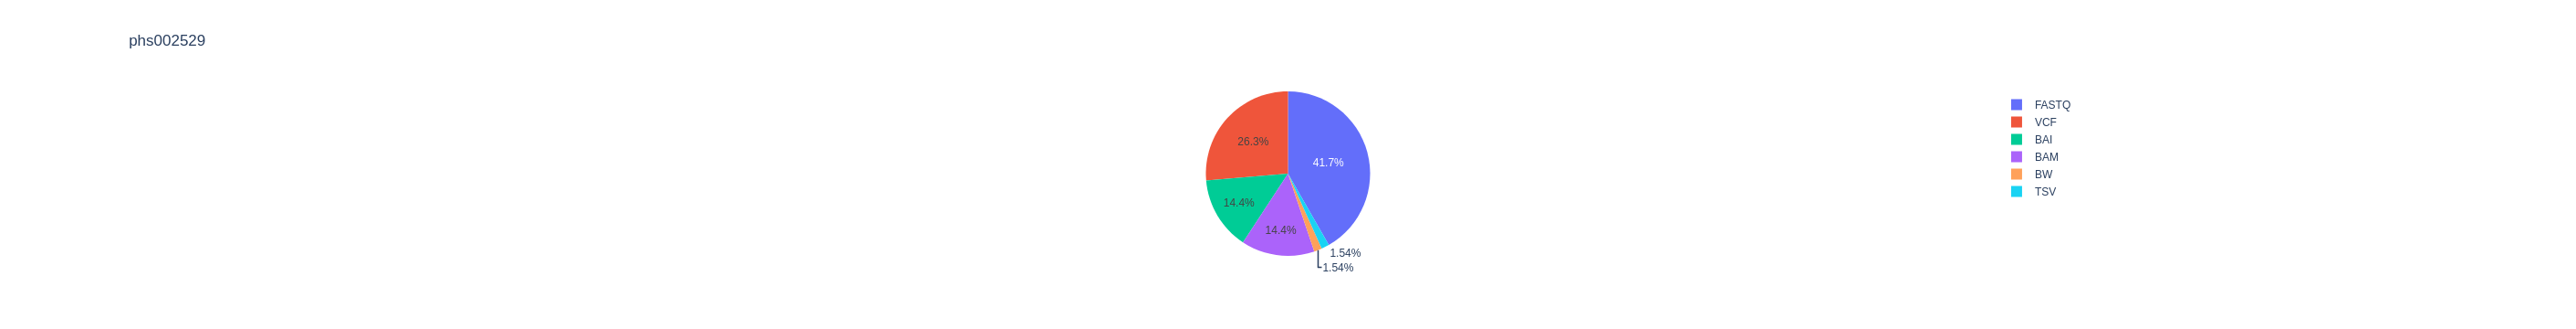

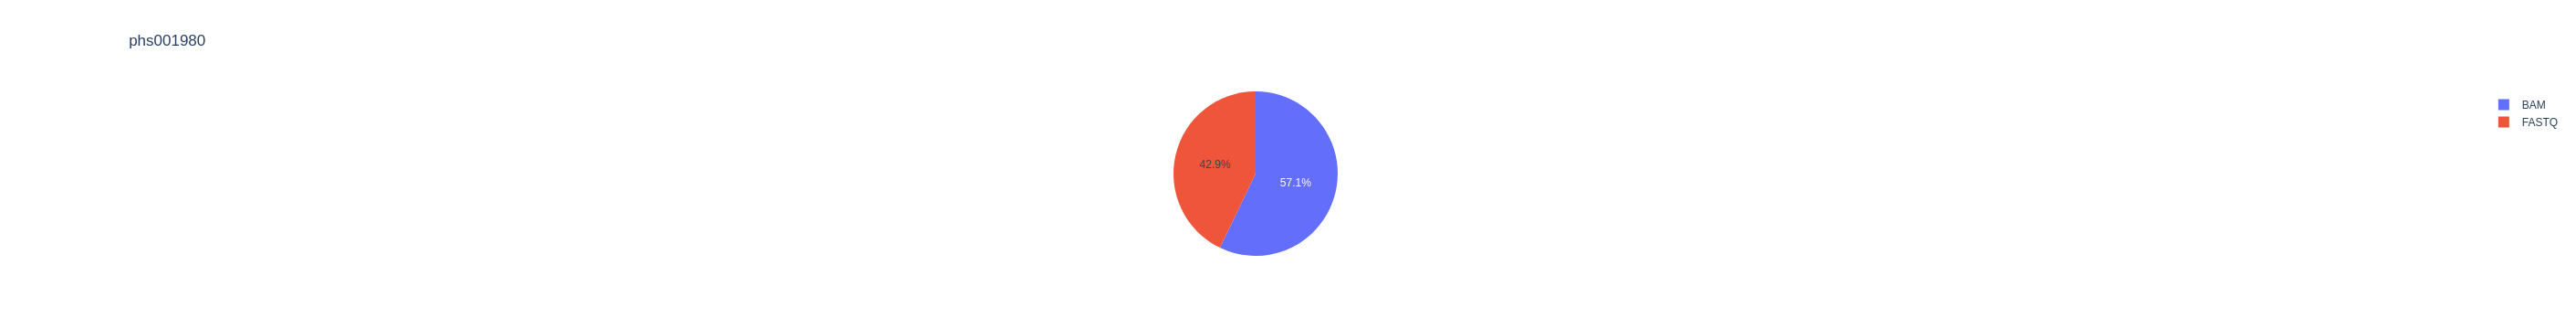

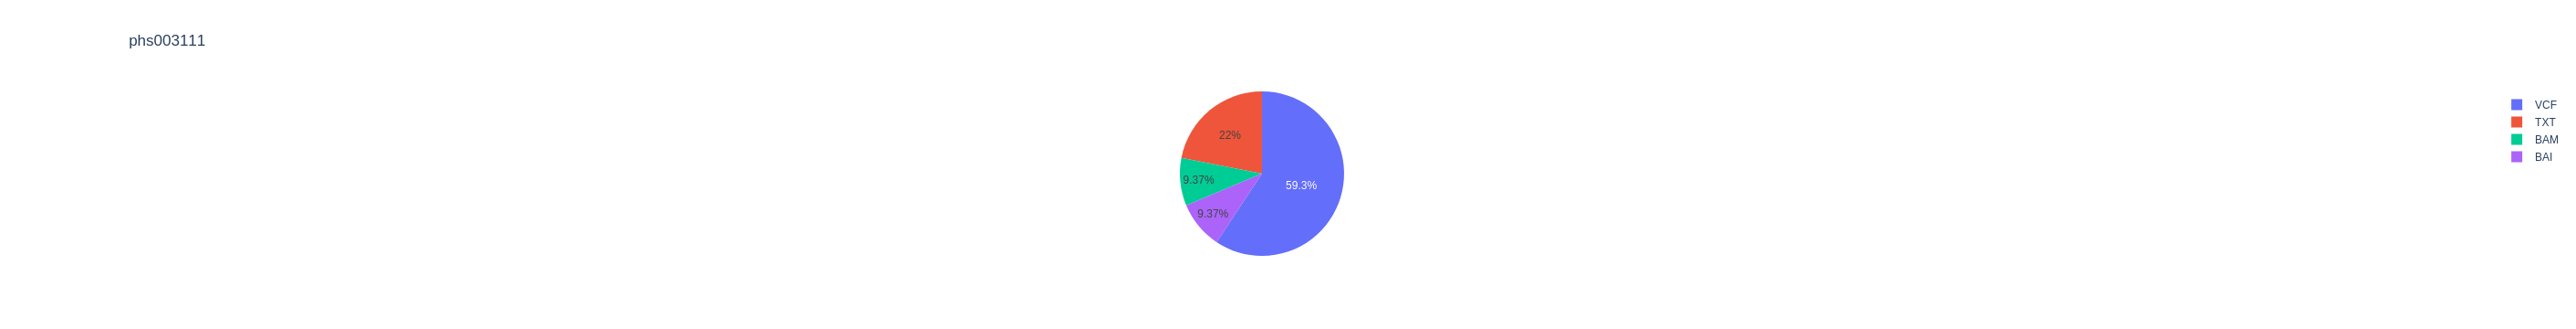

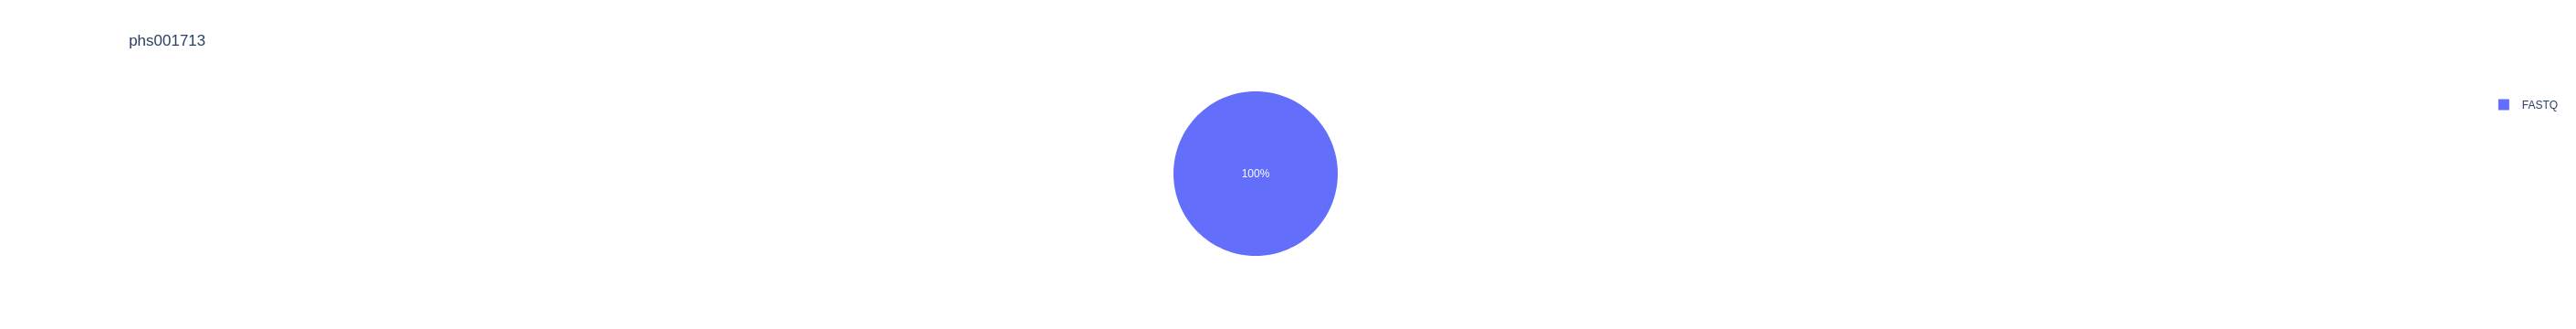

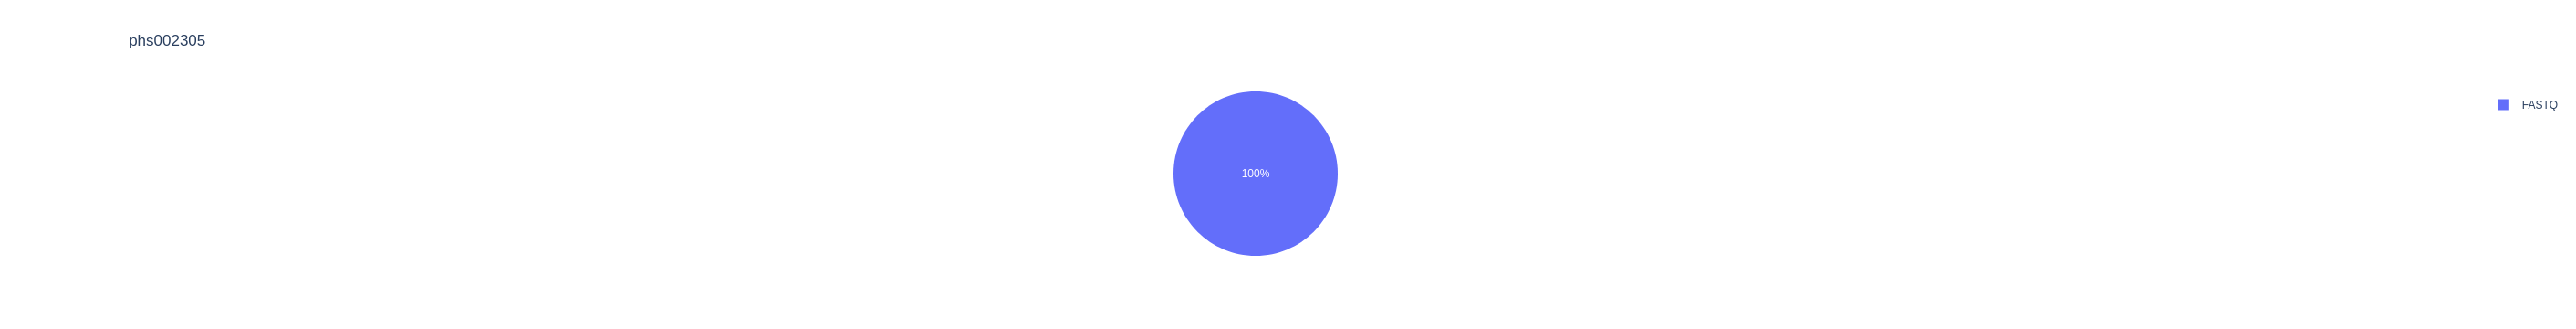

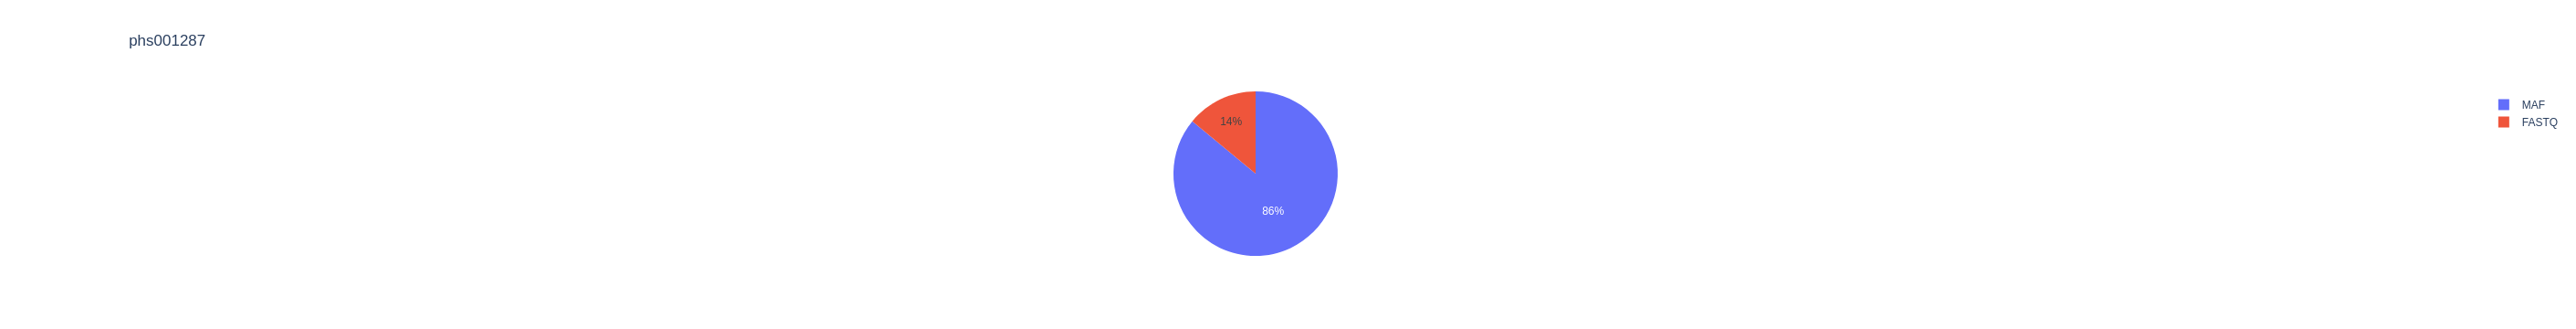

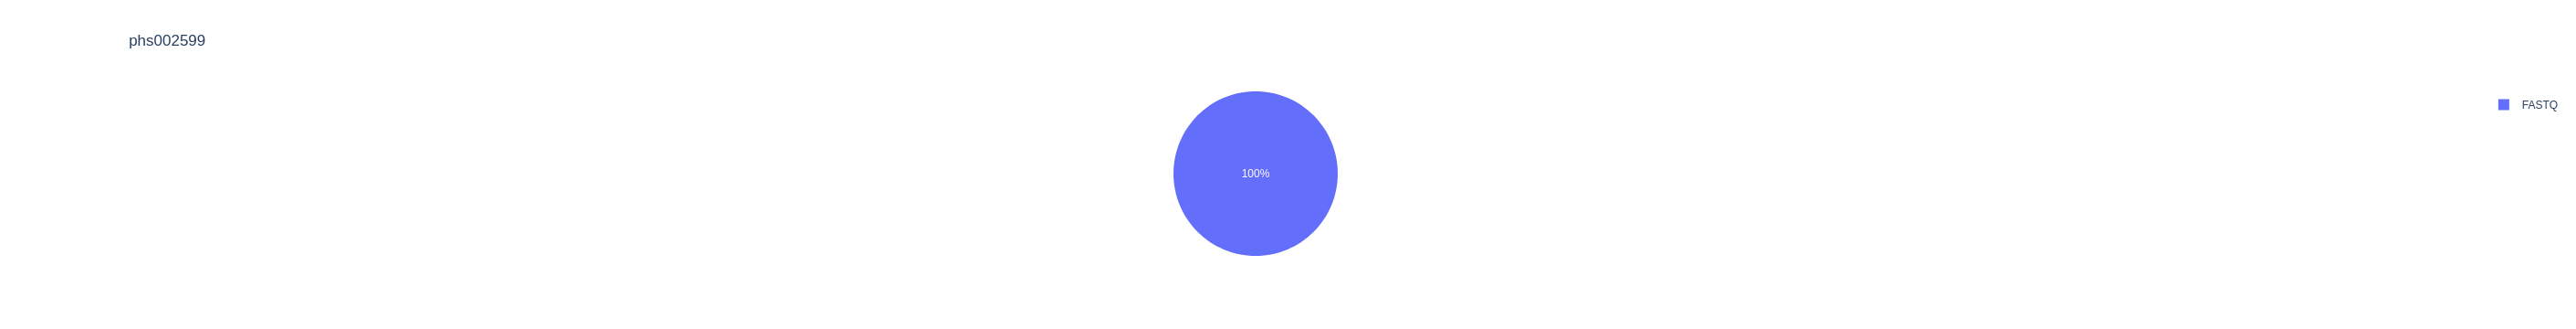

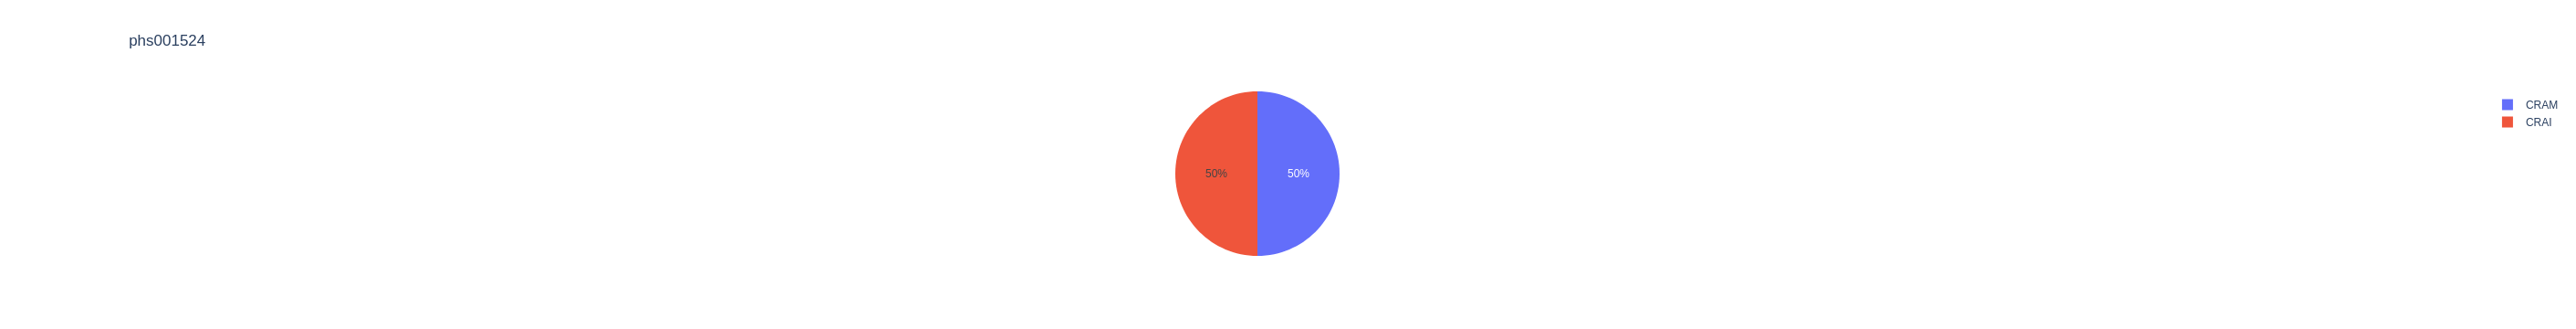

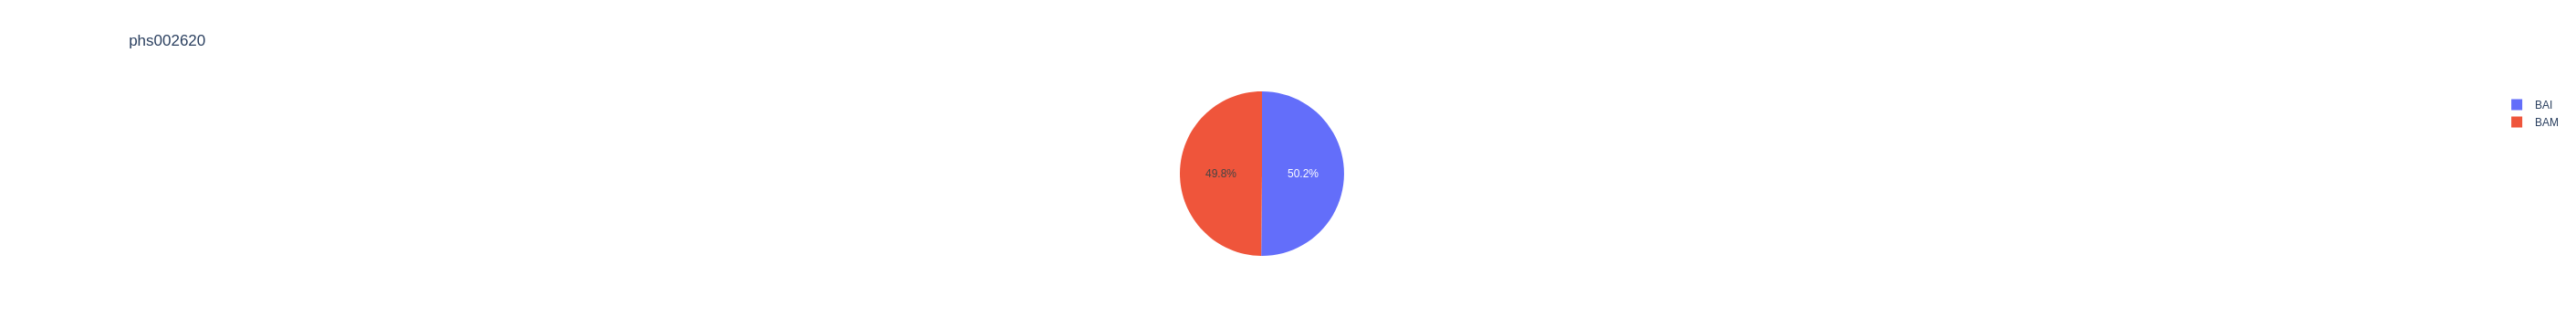

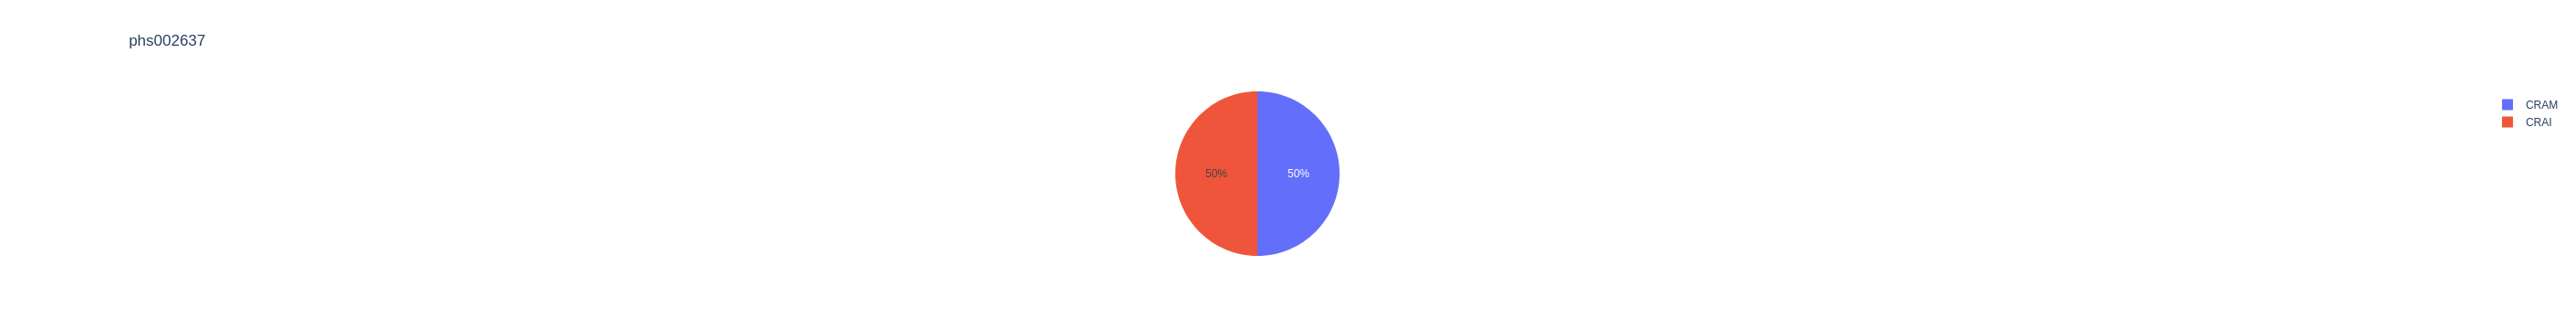

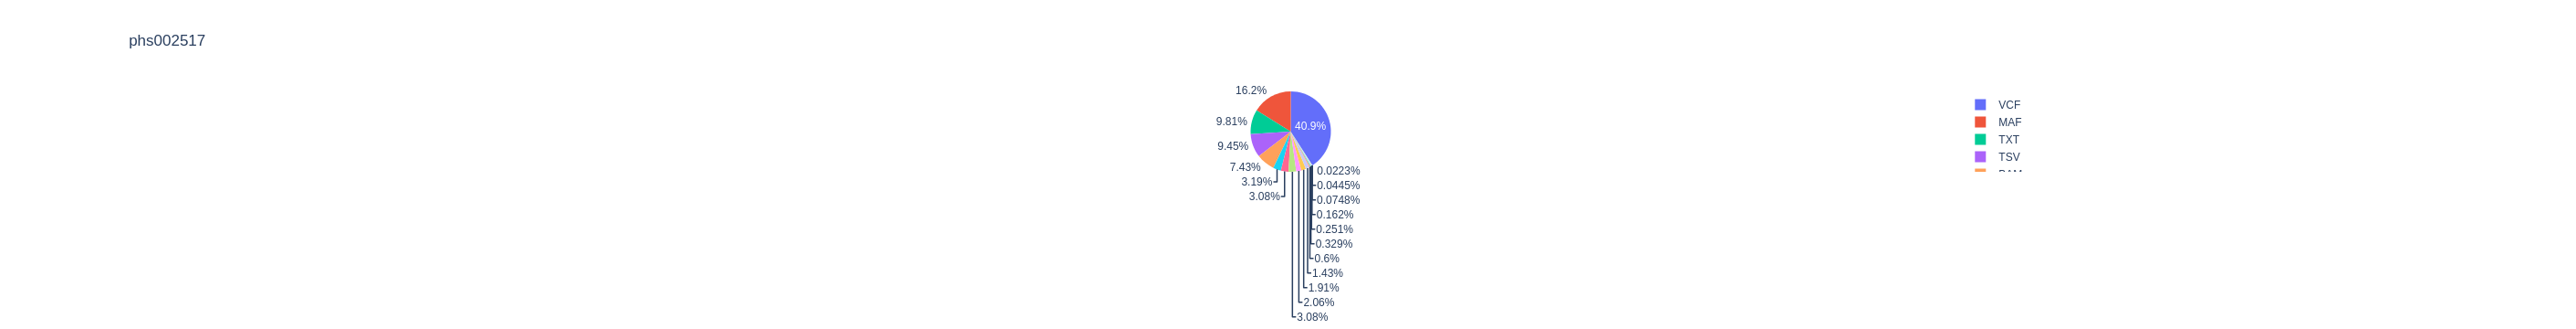

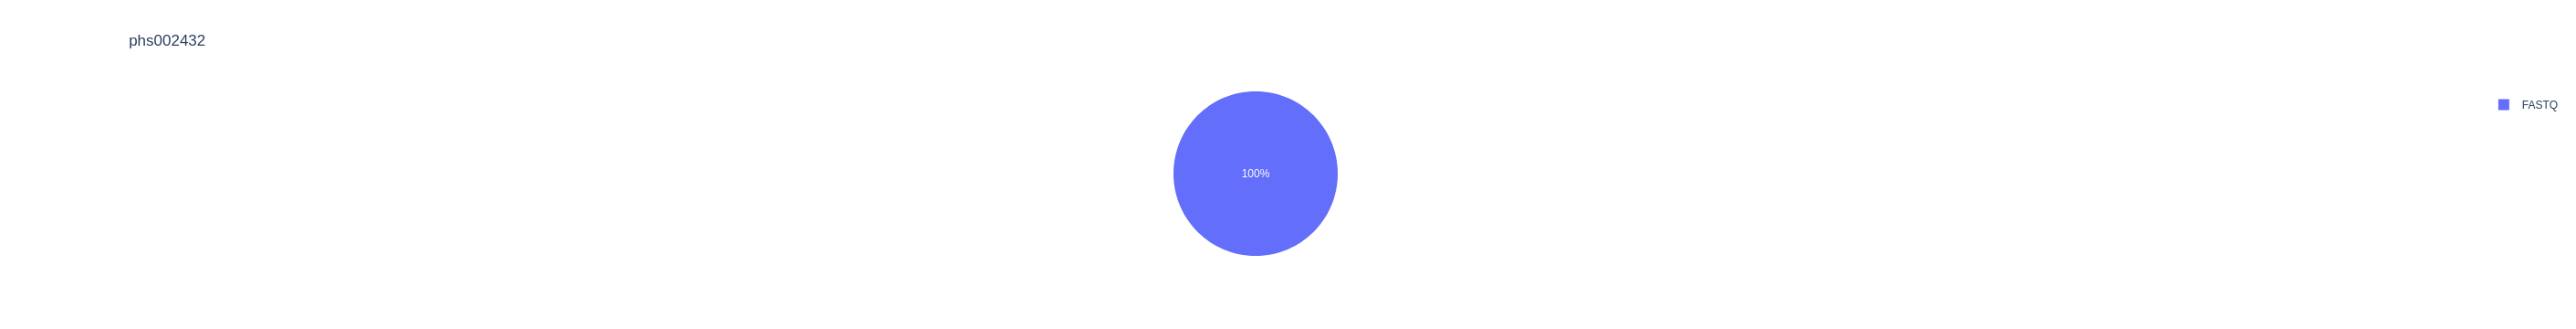

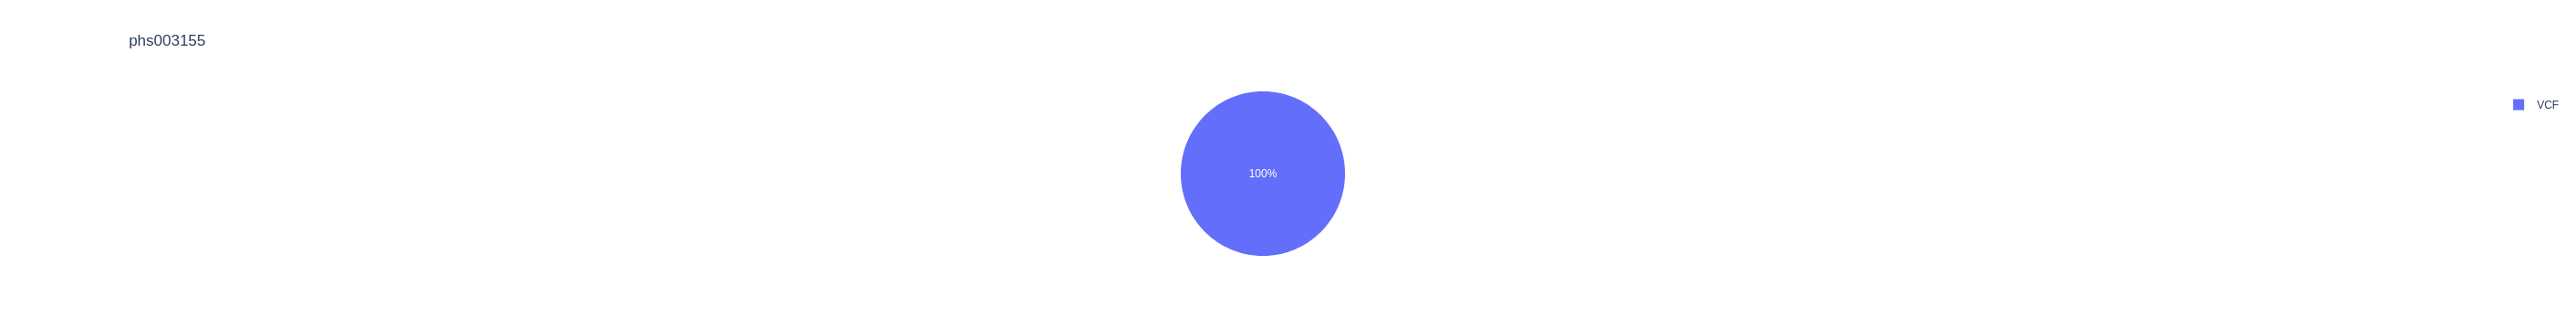

In [33]:
for phs in phslist:
    df2 = typecountdf.query("PHS==@phs")
    #pprint.pprint(df2)
    cats = df2['FileType']
    vals = df2['Count']
    fig = px.pie(df2, values='Count', names = 'FileType', title=phs)
    fig.show()

['phs002790',
 'phs002504',
 'phs002371',
 'phs002250',
 'phs002529',
 'phs001980',
 'phs003111',
 'phs001713',
 'phs002305',
 'phs001287',
 'phs002599',
 'phs001524',
 'phs002620',
 'phs002637',
 'phs002517',
 'phs002432',
 'phs003155']
